# Plot example data for a single patient

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import psycopg2
%matplotlib inline

In [2]:
# Config
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'public,mimiciii'

# append the search path to the beginning of each query
query_schema = 'set search_path to ' + schema_name + ';'

In [3]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [4]:
# Load elixhauser ahrq
query = query_schema + """
-- get first icu stay for adult patients
with t1 as 
(
select ie.icustay_id, ie.hadm_id, ie.intime, ie.outtime
, ROW_NUMBER() over (partition by ie.subject_id order by ie.intime) as icustay_num
from icustays ie
inner join admissions adm
on ie.hadm_id = adm.hadm_id
-- adult patient
inner join patients pat
on ie.subject_id = pat.subject_id
and ie.intime > pat.dob + interval '1' year
)
SELECT t1.icustay_id, a.*
FROM t1
left join elixhauser_ahrq a
on t1.hadm_id = a.hadm_id
where t1.icustay_num = 1
"""
ahrq = pd.read_sql_query(query,con)

# Load elixhauser ahrq no drg
query = query_schema + """
-- get first icu stay for adult patients
with t1 as 
(
select ie.icustay_id, ie.hadm_id, ie.intime, ie.outtime
, ROW_NUMBER() over (partition by ie.subject_id order by ie.intime) as icustay_num
from icustays ie
inner join admissions adm
on ie.hadm_id = adm.hadm_id
-- adult patient
inner join patients pat
on ie.subject_id = pat.subject_id
and ie.intime > pat.dob + interval '1' year
)
SELECT t1.icustay_id, a.*
FROM t1
left join elixhauser_ahrq_nodrg a
on t1.hadm_id = a.hadm_id
where t1.icustay_num = 1
"""
ahrq_nodrg = pd.read_sql_query(query,con)


# Load elixhauser quan
query = query_schema + """
-- get first icu stay for adult patients
with t1 as 
(
select ie.icustay_id, ie.hadm_id, ie.intime, ie.outtime
, ROW_NUMBER() over (partition by ie.subject_id order by ie.intime) as icustay_num
from icustays ie
inner join admissions adm
on ie.hadm_id = adm.hadm_id
-- adult patient
inner join patients pat
on ie.subject_id = pat.subject_id
and ie.intime > pat.dob + interval '1' year
)
SELECT t1.icustay_id, a.*
FROM t1
left join elixhauser_quan a
on t1.hadm_id = a.hadm_id
where t1.icustay_num = 1
"""
quan = pd.read_sql_query(query,con)

In [5]:
con.close()

In [6]:
# combine all conditions into a single dataframe
columns = [x for x in ahrq.columns if x not in ['subject_id','hadm_id','icustay_id']]
df = pd.concat([ahrq.sum(),ahrq_nodrg.sum(),quan.sum()],axis=1)#, quan.
df.drop(['subject_id','hadm_id','icustay_id'],axis=0,inplace=True)
df.columns = ['ahrq','ahrq_nodrg','quan']
df.reset_index(inplace=True)
df = pd.melt(df,id_vars='index')
df.head()

,index,variable,value
0,aids,ahrq,175.0
1,alcohol_abuse,ahrq,2782.0
2,blood_loss_anemia,ahrq,755.0
3,cardiac_arrhythmias,ahrq,6093.0
4,chronic_pulmonary,ahrq,6651.0


In [7]:
# define a dictionary to pretty up the legend
prettyLabel = {'ahrq': 'AHRQ',
               'ahrq_nodrg': 'AHRQ (No DRG filtering)',
               'quan': 'Quan et al.'}

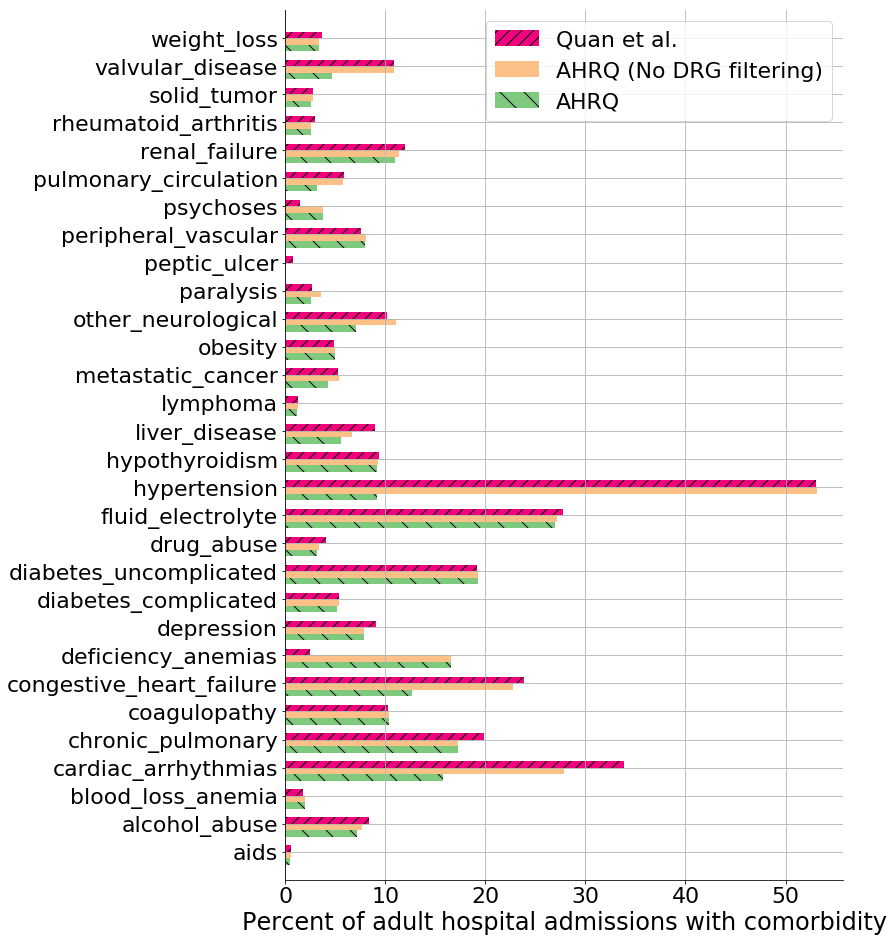

In [8]:
# Create a bar chart using the melted/"unpivoted" dataframe from above
# More info on how to have multi-category bar charts: 
#   http://emptypipes.org/2013/11/09/matplotlib-multicategory-barchart/
# Hatching examples (the patterns on each bar):
#   http://matplotlib.org/examples/pylab_examples/hatch_demo.html
plt.rcParams.update({'font.size': 22})
N = ahrq.shape[0]

fig = plt.figure(figsize=[10,16])
ax = fig.add_subplot(111)
space = 0.3

conditions = np.unique(df['index'].values)
categories = np.unique(df['variable'].values)

n = len(conditions)

width = (1 - space) / (len(categories))

hatch={'quan': '//', 'ahrq': '\\', 'ahrq_nodrg': ''}
for i, c in enumerate(categories):
    val = df.loc[df['variable'] == c,'value'].astype(float) / N * 100.0
    pos = [j - (1 - space) / 2. + i * width for j in range(1,len(conditions)+1)]
    ax.barh(pos, val, height=width, label=c, hatch=hatch[c],
       color=cm.Accent(float(i) / len(categories)))
    
ax.set_yticks([x+1 for x in range(len(conditions))])
ax.set_yticklabels(conditions)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], [prettyLabel[x] for x in labels[::-1]], loc='upper right')
plt.grid()

plt.xlabel('Percent of adult hospital admissions with comorbidity',fontsize=24)

# pretty up the plot
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
ax.set_ylim([0,31])

plt.show()
fig.savefig('comorbidity.png', bbox_inches='tight')